In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import processing
from utils import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

In [4]:
kld = kld[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'qrtr_sin', 'qrtr_cos']]
stb = stb[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'qrtr_sin', 'qrtr_cos']]

In [43]:
# Processing Parameters
split = 0.80 # split percentage for training data
steps = 1 # timesteps: 1 hour

lookback = 24 * 30 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 32
epochs = 50
lr = 0.001

In [44]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.create_datasets(kld, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.create_datasets(stb, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [45]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (32, 720, 9)
Target Shape: (32, 1)


In [56]:
model = Sequential()

model.add(Input(shape=(inputs.shape[1], inputs.shape[2])))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(GRU(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(GRU(32, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(32))

model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=['mae'])



In [57]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 718, 64)           1792      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 359, 64)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 359, 64)           24960     
_________________________________________________________________
dropout_17 (Dropout)         (None, 359, 64)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)              

In [58]:
# Callbacks
ckpt_path = "../model/models/cnn_gru_fnn_model.h5"
estp = EarlyStopping(monitor='val_loss', patience=10)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [59]:
history = model.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
456/456 [==============================] - 121s 257ms/step - loss: 0.8120 - mae: 0.6911 - val_loss: 0.7411 - val_mae: 0.6139

Epoch 00001: val_loss improved from inf to 0.74109, saving model to ../model/models\cnn_gru_fnn_model.h5
Epoch 2/50
456/456 [==============================] - 119s 261ms/step - loss: 0.4543 - mae: 0.5033 - val_loss: 0.4244 - val_mae: 0.4820

Epoch 00002: val_loss improved from 0.74109 to 0.42436, saving model to ../model/models\cnn_gru_fnn_model.h5
Epoch 3/50
456/456 [==============================] - 119s 260ms/step - loss: 0.2844 - mae: 0.4064 - val_loss: 0.3025 - val_mae: 0.4120

Epoch 00003: val_loss improved from 0.42436 to 0.30253, saving model to ../model/models\cnn_gru_fnn_model.h5
Epoch 4/50
456/456 [==============================] - 115s 253ms/step - loss: 0.2464 - mae: 0.3795 - val_loss: 0.3429 - val_mae: 0.4356

Epoch 00004: val_loss did not improve from 0.30253
Epoch 5/50
456/456 [==============================] - 116s 254ms/step - loss: 

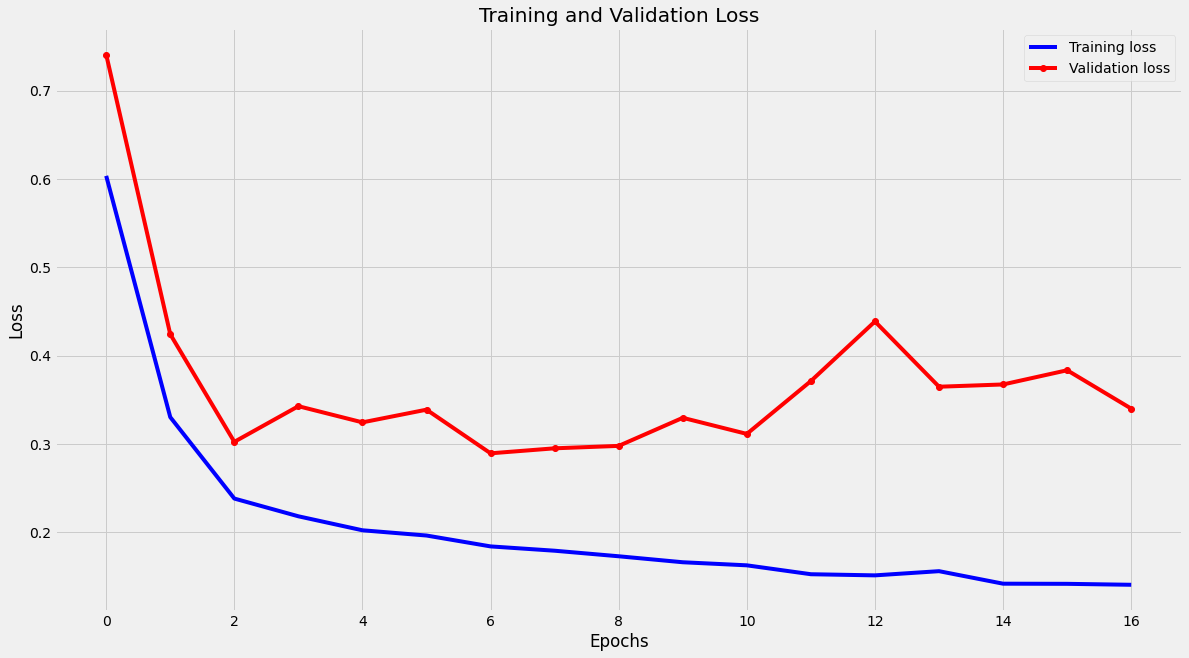

In [60]:
utils.plot_training(history, "Training and Validation Loss")